In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Full data set will be cleaned up prior to splitting into train, test and final.

Put completed_loans_2017.csv file in ./Data/ for this notebook to run.

# Initial Data Load and Clean Up

In [5]:
data = pd.read_csv('./Data/completed_loans_2017.csv', low_memory=0)

In [6]:
rows, columns = data.shape
data.shape

(263720, 150)

150 columns, just over 1/4 million lines.

In [7]:
missing_values = pd.DataFrame((data.isnull().sum()/rows)* 100, columns=["% Missing Values"])
missing_values["Missing_Values"] = missing_values["% Missing Values"] > 0
cols_with_missing_values = missing_values[missing_values.Missing_Values].index
missing_values[missing_values.Missing_Values].describe()

,% Missing Values
count,62.000000
mean,66.972259
std,42.121467
min,0.000379
25%,7.883930
50%,92.705521
75%,99.137722
max,100.000000


62 columns with missing values with some up to 100% missing.

In [8]:
data.loan_status = (data.loan_status == "Charged Off").astype('int8')

In [9]:
data.loan_status.mean()

0.23006977096920977

Default rate is 23%

In [10]:
non_numerical_columns = data.columns[data.dtypes=="object"]
non_numerical_columns.shape

(35,)

There are 35 columns that are not numerical, some may be formatting, others will need encoding.

In [11]:
non_nums = (data[non_numerical_columns][70:74].T)
non_nums['unique'] = data[non_numerical_columns].nunique()
non_nums.sort_values('unique', ascending=0)


,70,71,72,73,unique
url,https://lendingclub.com/browse/loanDetail.acti...,https://lendingclub.com/browse/loanDetail.acti...,https://lendingclub.com/browse/loanDetail.acti...,https://lendingclub.com/browse/loanDetail.acti...,263720
emp_title,VIP Art Associate,Court Liaison,Senior Account Manager,Machine Operator,79726
revol_util,81.5%,95.2%,84.3%,11.2%,1117
zip_code,113xx,088xx,640xx,372xx,891
earliest_cr_line,Jan-2002,Mar-1991,Apr-2002,May-2007,666
sec_app_earliest_cr_line,NaN,NaN,NaN,NaN,566
int_rate,11.49%,14.99%,14.99%,23.99%,67
addr_state,NY,NJ,MO,TN,50
last_credit_pull_d,Nov-2018,Jan-2019,May-2018,Jan-2020,39
last_pymnt_d,Jun-2018,Feb-2019,May-2018,Feb-2019,38


There are a few columns that are dates and % which can be enumerated.

In [12]:
pctstr_cols = ['int_rate', 'revol_util']
datestr_cols = ['issue_d','earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d',\
                'settlement_date','payment_plan_start_date','hardship_end_date',\
               'debt_settlement_flag_date','hardship_start_date','sec_app_earliest_cr_line']
def pcent_to_float(df, col):
    return df[df[col].notnull()][col].apply(lambda x: (str(x)[:-1])).astype('float16')
def date_to_int(df, col):
    return ((pd.to_datetime(df[df[col].notnull()][col]) - pd.to_datetime(df[df[col].notnull()][col]).min())/ (10**11)).astype('int64').astype('int32')

url is just link to the loan page and emp_title has too much dimensionality to be of use with this data set so will be removed.

In [13]:
non_numerical_columns = list(set(non_numerical_columns) - set(pctstr_cols) - set(datestr_cols))
remove_cols = [non_numerical_columns.pop(non_numerical_columns.index('url'))]
remove_cols.append(non_numerical_columns.pop(non_numerical_columns.index('emp_title')))

In [14]:
remove_cols.append('id')
remove_cols.append('Unnamed: 0')


In [15]:
non_numerical_columns

['grade',
 'purpose',
 'settlement_status',
 'term',
 'application_type',
 'pymnt_plan',
 'zip_code',
 'hardship_status',
 'debt_settlement_flag',
 'hardship_type',
 'title',
 'initial_list_status',
 'hardship_reason',
 'addr_state',
 'hardship_flag',
 'sub_grade',
 'verification_status',
 'verification_status_joint',
 'home_ownership',
 'emp_length',
 'hardship_loan_status']

In [16]:
del data

# Train Test Final Clean Up

In [17]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
final = pd.read_csv('Data/final.csv')
files = [train, test, final]

In [18]:
non_numerical_columns = list(set(non_numerical_columns)-
                             set(['hardship_flag', 'hardship_type', 'pymnt_plan']))

In [19]:
for file in files:
    for col in pctstr_cols:
        file[col] = pcent_to_float(file, col)
    for col in datestr_cols:
        file[col] = date_to_int(file, col)
    file.drop(remove_cols, axis = 1, inplace=True)


In [20]:
le = LabelEncoder()

In [21]:
for file in files:
    for col in non_numerical_columns:
        le.fit(file[col].astype('str'))
        file[col] = le.transform(file[col].astype('str'))

# Variable Importance from RF

In [22]:
y_train = train.loan_status
y_test = test.loan_status
y_final = final.loan_status
X_train = train.drop('loan_status', axis=1)
X_test = test.drop('loan_status', axis=1)
X_final = final.drop('loan_status', axis=1)

In [23]:
X_train.fillna(0, inplace=True)

In [24]:
fitrf = RandomForestClassifier(n_estimators = 500, oob_score = True, min_samples_leaf = 10)

In [25]:
fitrf.fit(X_train, y_train)
None

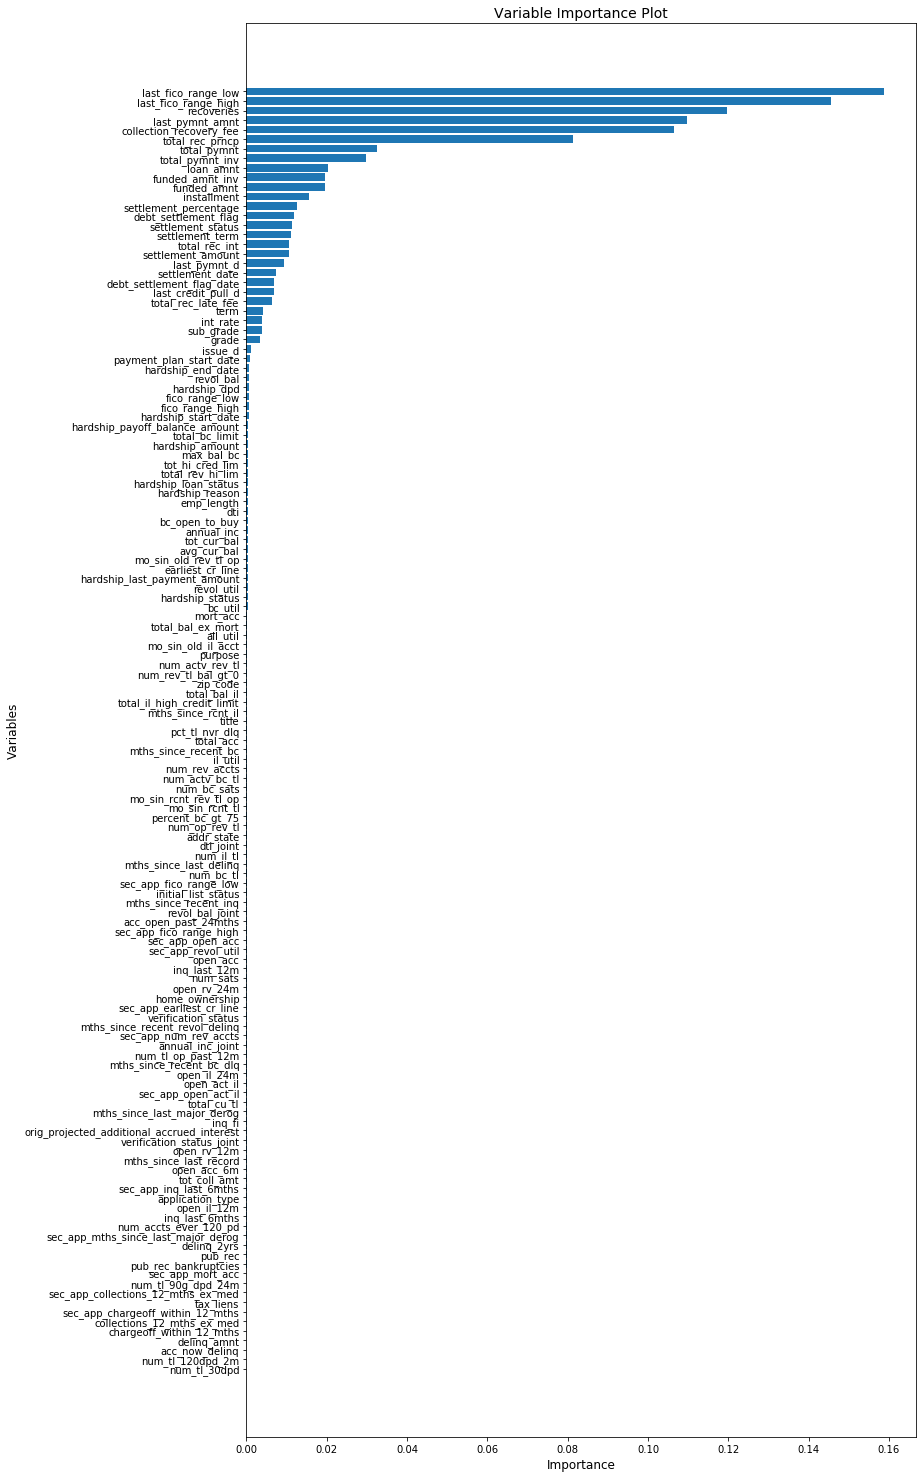

In [35]:
X_features = list(X_train.columns)
rf_importances = fitrf.feature_importances_
indices = np.argsort(rf_importances)

fig = plt.figure(figsize=[12,26])
axs = fig.subplots(1,1)
plt.yticks(range(len(indices)), [X_features[i] for i in indices])
axs.barh(range(len(indices)), rf_importances[indices], align='center')
axs.set_title("Variable Importance Plot", size ='14')
axs.set_ylabel("Variables", size='12'); axs.set_xlabel("Importance", size='12')
None


In [27]:
from pdpbox import pdp, get_dataset, info_plots

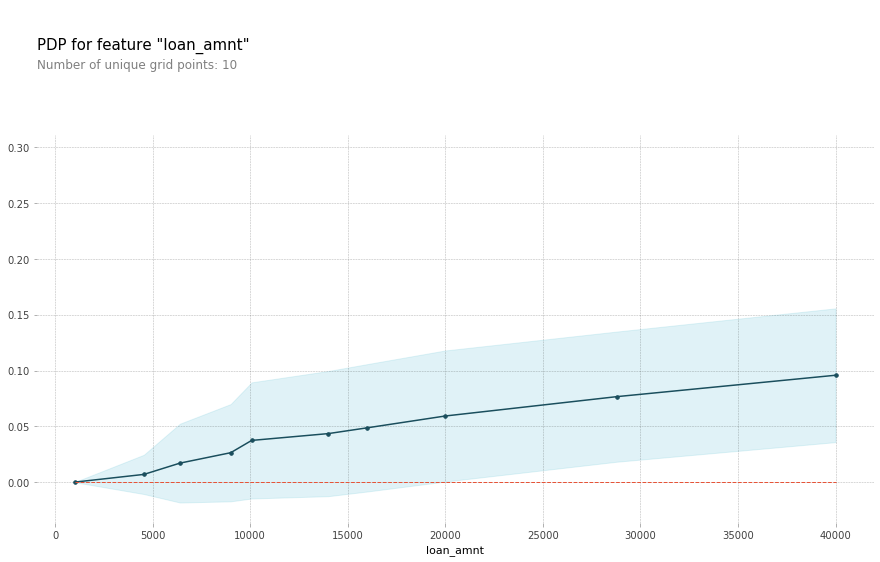

In [34]:
pdp_obj = pdp.pdp_isolate(model = fitrf, dataset = X_train, model_features = X_features, feature = 'loan_amnt')
fig, axes = pdp.pdp_plot(pdp_obj, 'loan_amnt')
None

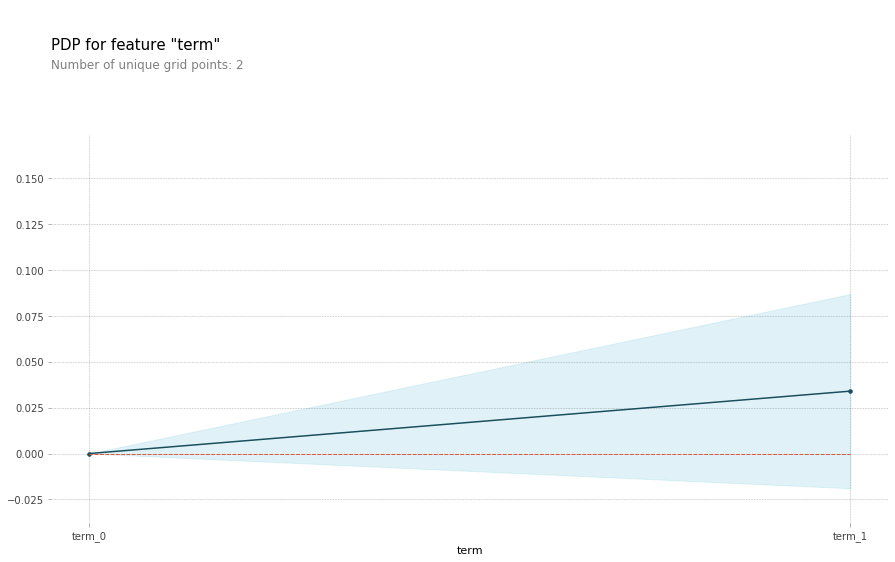

In [35]:
pdp_obj = pdp.pdp_isolate(model = fitrf, dataset = X_train, model_features = X_features, feature = 'term')
fig, axes = pdp.pdp_plot(pdp_obj, 'term')
None

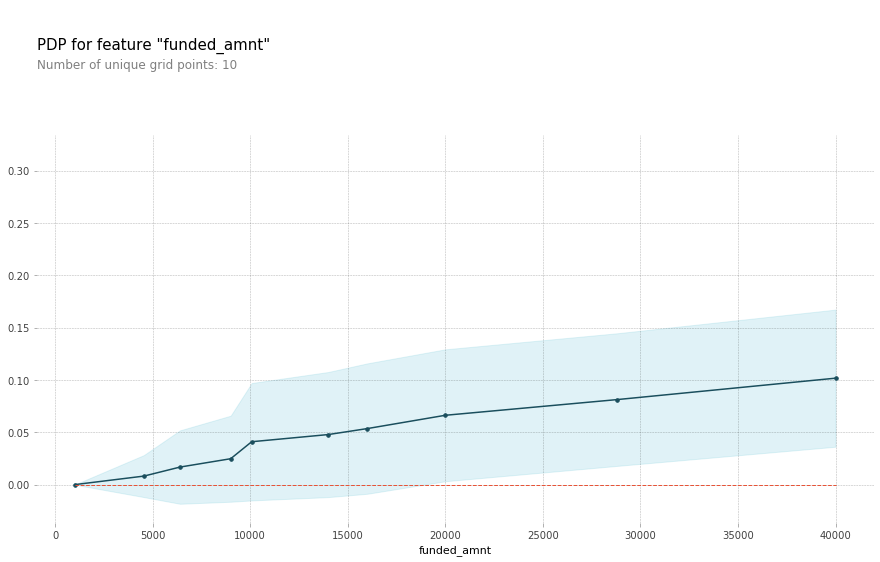

In [36]:
pdp_obj = pdp.pdp_isolate(model = fitrf, dataset = X_train, model_features = X_features, feature = 'funded_amnt')
fig, axes = pdp.pdp_plot(pdp_obj, 'funded_amnt')
None

In [44]:
top20 = [X_features[i] for i in indices[-20:]]


In [55]:
definitions = pd.read_excel('./Data/LCDataDictionary.xlsx', index_col=0)

In [59]:
definitions.loc[top20]

,Description
LoanStatNew,
settlement_date,The date that the borrower agrees to the settl...
last_pymnt_d,Last month payment was received
settlement_amount,The loan amount that the borrower has agreed t...
total_rec_int,Interest received to date
settlement_term,The number of months that the borrower will be...
settlement_status,The status of the borrower’s settlement plan. ...
debt_settlement_flag,"Flags whether or not the borrower, who has cha..."
settlement_percentage,The settlement amount as a percentage of the p...
installment,The monthly payment owed by the borrower if th...
